<a href="https://colab.research.google.com/github/vishwanath103/MIT-DL-Course/blob/main/Debiasing_Facial_Detection_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Two prominent aspects of appliead deep learning:
- Facial detection
- Algorithmic bias

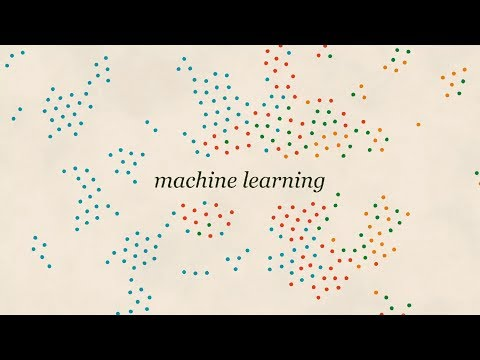

In [1]:
import IPython
IPython.display.YouTubeVideo('59bMh59JQDo')

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1MB 8.7MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-cp37-none-any.whl size=2115442 sha256=61aa58b4ef44ff4a6a41aa703baabff877fbfc164bfc4f6494a33d96b2ca2a7b
  Stored in directory: /root/.cache/pip/wheels/af/dc/2a/5c3633135e7e4ef4fd31463cfa1942cb1bae7486ab94e7a2ad
Successfully built mitdeeplearning


## Datasets

In [3]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263894528/1263889489 [==============================] - 9s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [4]:
number_of_training_data = loader.get_train_size()
(images, labels) = loader.get_batch(100)

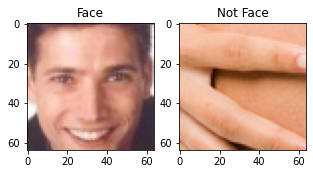

In [5]:
### Examining the CelebA training dataset ###

#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 23 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 6 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

## CNN for facial detection

### Define and train the CNN model

In [6]:
### Define the CNN Model ###

n_filters = 12

def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
        Conv2D(filters=1*n_filters, kernel_size=5, strides=2),
        BatchNormalization(),

        Conv2D(filters=2*n_filters, kernel_size=5, strides=2),
        BatchNormalization(),

        Conv2D(filters=4*n_filters, kernel_size=3, strides=2),
        BatchNormalization(),

        Conv2D(filters=6*n_filters, kernel_size=3, strides=2),
        BatchNormalization(),

        Flatten(),
        Dense(512),
        Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()
print(standard_classifier)

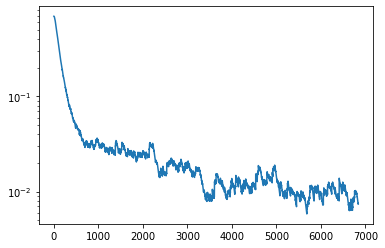

100%|██████████| 3434/3434 [03:54<00:00, 14.61it/s]


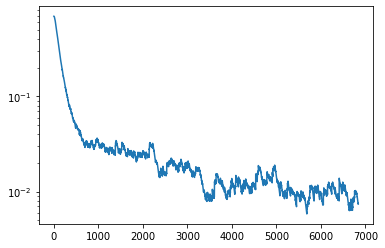

In [7]:
### Train the standard CNN ###

# Training hyperparameters
batch_size = 32
num_epochs = 2
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

@tf.function
def standard_train_step(x,y):
  with tf.GradientTape() as tape:
    logits = standard_classifier(x)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    x,y = loader.get_batch(batch_size)
    loss = standard_train_step(x,y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

### Evaluate the performance of the standard CNN

In [8]:
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) training set: 0.9942


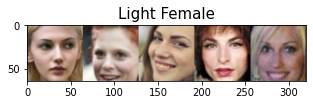

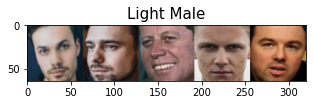

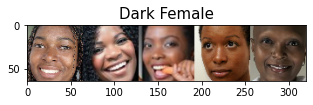

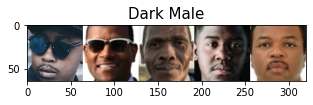

In [9]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys): 
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

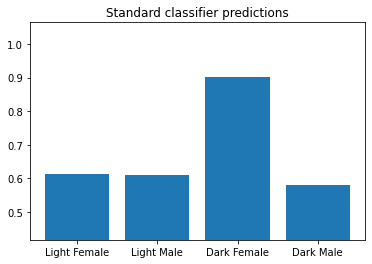

In [10]:
### Evaluate the standard CNN on the test data ### 

standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions");

## Variational autoencoder (VAE)

In [11]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x, 
      reconstructed output x_recon, 
      encoded means mu, 
      encoded log of standard deviation logsigma, 
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

In [12]:
def sampling(z_mean, z_logsigma):
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  return z

### Debaising variational autoencoder (DB-VAE)

In [13]:
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)

  face_indicator = tf.cast(tf.equal(y,1), tf.float32)

  total_loss = tf.reduce_mean(
      classification_loss +
      face_indicator * vae_loss
  )

  return total_loss, classification_loss

### DB-VAE Architecture

In [14]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12
latent_dim = 100

def make_face_decoder_network():
  # Functionally define the different layer types
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
            # Transoform to pre-conolutional generation
            Dense(units=4*4*6*n_filters),
            Reshape(target_shape=(4,4,6*n_filters)),

            # UPscaling convolutions (inverse of encoder)
            Conv2DTranspose(filters=4*n_filters, kernel_size=3, strides=2),
            Conv2DTranspose(filters=2*n_filters, kernel_size=3, strides=2),
            Conv2DTranspose(filters=1*n_filters, kernel_size=5, strides=2),
            Conv2DTranspose(filters=3, kernel_size=5, strides=2),
  ])

  return decoder

In [27]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # Function to feed images into encoder, encode the latent space and output 
  # the classification probability
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:,0], -1)
    # Latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE representation: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x):
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # Reparameterization
    z = self.reparameterize(z_mean, z_logsigma)

    # Reconstruction
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

### Adaptive resampling

In [28]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [31]:
### Resampling algorithm for DB-VAE ###

def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
  print("Recomputing the sampling probabilities")

  # Run the input batch and get the latent variable means
  mu = get_latent_mu(images, dbvae)

  # Sampling probabilities for the images
  training_sample_p = np.zeros(mu.shape[0])

  # Consider the distribution for each latent variable
  for i in range(latent_dim):

    latent_distribution = mu[:,i]
    # Generate a histogram of the latent distribution
    hist_density, bin_edges = np.histogram(latent_distribution, density=True, bins=bins)

    # find which latent bin every data sample falls in
    bin_edges[0] = -float('inf')
    bin_edges[-1] = float('inf')

    # find which bins in the latent distribution every data sample falls in to
    bin_idx = np.digitize(latent_distribution, bin_edges)

    # smooth the density function
    hist_smoothed_density = hist_density + smoothing_fac
    hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)
    
    # invert the density function
    p = 1.0/(hist_smoothed_density[bin_idx-1])

    # normalize all probabilities
    p = p/np.sum(p)

    training_sample_p = np.maximum(p, training_sample_p)

  training_sample_p /= np.sum(training_sample_p)
  return training_sample_p

Starting epoch 6/6
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

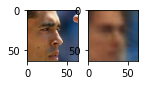

 15%|█▍        | 500/3434 [00:58<05:37,  8.70it/s]

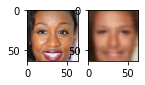

 29%|██▉       | 1000/3434 [01:56<04:46,  8.49it/s]

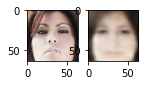

 44%|████▎     | 1500/3434 [02:54<03:41,  8.71it/s]

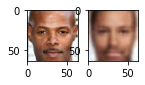

 58%|█████▊    | 2000/3434 [03:53<02:46,  8.60it/s]

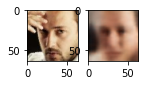

 73%|███████▎  | 2500/3434 [04:52<01:47,  8.71it/s]

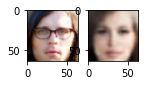

 87%|████████▋ | 3000/3434 [05:50<00:50,  8.60it/s]

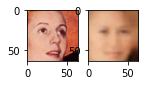

100%|██████████| 3434/3434 [06:42<00:00,  8.54it/s]


In [32]:
### Training the DB-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

# DB-VAE needs slightly more epochs based on its complexity
num_epochs = 6

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

  grads = tape.gradient(loss, dbvae.trainable_variables)
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear()

# The training loop
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling probabilities
  p_faces = get_training_sample_probabilities(all_faces, dbvae)

  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    (x,y) = loader.get_batch(batch_size, p_pos=p_faces)
    loss = debiasing_train_step(x,y)

    if j%500 == 0:
      mdl.util.plot_sample(x,y,dbvae)

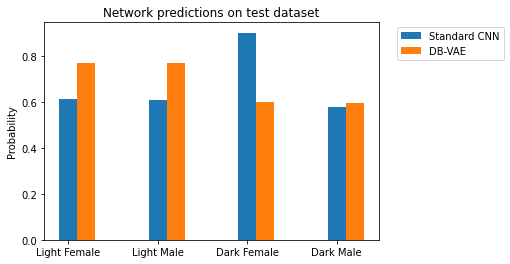

In [33]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");